# Homework #5: Approximate Bayesian Computation

Janelle Sy

December 12, 2022

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import pickle as pkl
from scipy import optimize
from scipy import stats

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED



***Problem 1: Learn the hyperparameters of a Gaussian process kernel by Approximate Bayesian Computation. You will need a GP implementation (your own, or you can use scikit-learn or tinygp or whatever) in which you can make draws from the prior over functions. You will also need the small data set provided (on Discord) for this problem. And you will need to choose some broad prior over the two parameters of the Matérn 3/2 kernel. Make your convex distance function on the data directly, so that a trial function gets a good (low) score if it matches all N data points nearly exactly. Obtain a good posterior sampling with a few hundred ABC-generated posterior samples.
Bonus points: Compare the posterior sampling you get from ABC to the true posterior, which you can compute the old-school way.***

In [2]:
#lets extract the data

filename = 'data_ps6.pkl'

with open(filename, "rb") as handle:
    x, y = pkl.load(handle)

In [3]:
print('x = ', x)
print('y = ', y)

x =  [23.97056761 60.84571561 46.84761228 38.31414299  9.98519299  9.9836493
  3.71735118 55.43527333]
y =  [ 1.77757348  6.91964447  0.68496139 -2.07247794  4.29285714  4.29253515
  1.97837488  5.18046756]


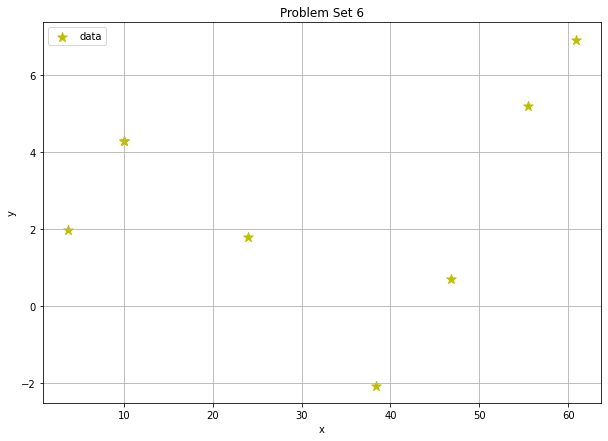

In [4]:
plt.figure(figsize=(10, 7))

plt.scatter(x, y, color= "y", marker= "*", s = 100, label = 'data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Problem Set 6')
plt.grid()
plt.legend()
plt.show()

## Implement Approximate Bayesian Computation:

- need priors on everything
- draw from the prior
- simulate
- get statistic $\tilde{p}(k)$
- compare to data w/ convex metric $\rho(\tilde{p}(k),p(k))$
- if $\rho(...) < \epsilon $ --> accept
- if $\rho(...) > \epsilon $ --> reject

In [5]:
rng = np.random.default_rng(42)

In [6]:
def matern(x_1, x_2, tau, sigma):
    return sigma**2*(1 + np.sqrt(3)*np.abs(x_1[:, None] - x_2[None, :])/tau)*np.exp(-1*np.sqrt(3)*np.abs((x_1[:, None] - x_2[None, :]))/tau)

In [7]:
def prior(pars, rng=rng):
    sigma2 = pars[0] + (pars[1] - pars[0]) * rng.uniform()
    tau = pars[2] + (pars[3] - pars[2]) * rng.uniform()
    
    return sigma2, tau

def sim(x, pars, rng=rng):
    sigma2, tau = prior(pars, rng=rng)
    var = matern(x, x, sigma2, tau)
    
    return sigma2, tau, rng.multivariate_normal(0. * x, var)

In [8]:
prior_pars = np.array([10., 100., 1., 10.])
sigma2, tau, sim_y = sim(x, prior_pars)

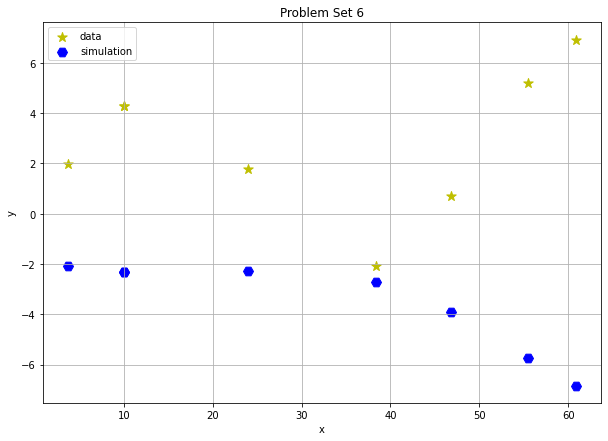

In [9]:
plt.figure(figsize=(10, 7))

plt.scatter(x, y, color= "y", marker= "*", s = 100, label = 'data')
plt.scatter(x, sim_y, color= "b", marker= "H", s = 100, label = 'simulation')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Problem Set 6')
plt.grid()
plt.legend()
plt.show()

In [10]:
def accept_reject(x, ys, simulate, pars, epsilon):
    
    sigma2, tau, sim_y = simulate(x, pars)
    accept = False
    
    if np.sum(np.abs(y - sim_y)) < epsilon:
        accept = True
        
    return accept, sigma2, tau

In [11]:
def abc(x, y, simulate, pars, epsilon, N):
    
    mask = np.zeros(N).astype(bool)
    result = []
    
    for n in range(N):
        m, sigma2, tau = accept_reject(x, y, simulate, pars, epsilon)
        mask[n] = m
        result += [(sigma2, tau)]
        
    return mask, np.array(result)

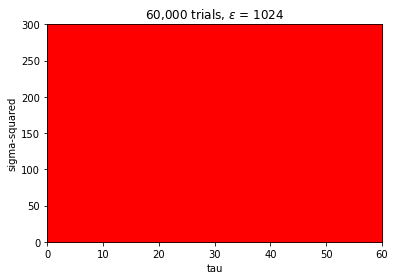

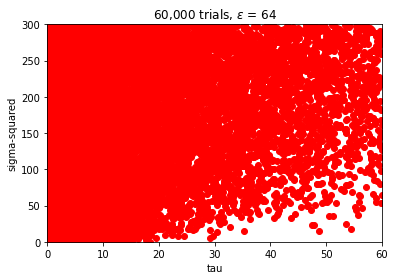

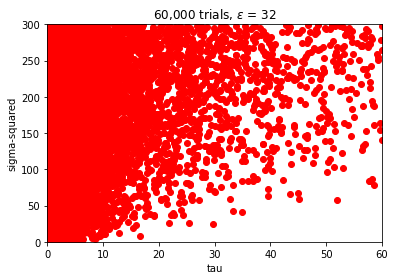

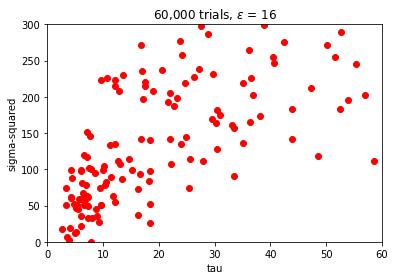

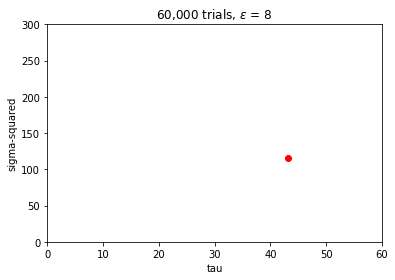

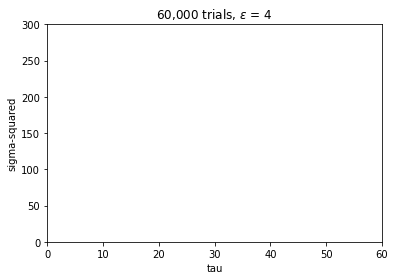

In [12]:
prior_pars = np.array([0., 300., 0., 60.])

for value in ["1024", "64", "32", "16", "8", "4"]:
    epsilon = float(value)
    mask, pars = abc(x, y, sim, prior_pars, epsilon, 60000)
    plt.figure()
    plt.plot(pars[mask, 1], pars[mask, 0], "ro")
    plt.ylabel("sigma-squared")
    plt.xlabel("tau")
    plt.xlim(prior_pars[2], prior_pars[3])
    plt.ylim(prior_pars[0], prior_pars[1])
    plt.title(r"60,000 trials, $\epsilon$ = " + value)

***Problem 2: Re-do the regression of Problem Set 5, Problem 1, but now using a neural network. Either build your own, or else use a canned implementation from jax, pytorch, TensorFlow, or scikit-learn. Compare your results to your Problem Set 5 results. The deep learning results will be substantially better, right?***


In [13]:
#lets extract the data

train_file = 'ap17_xpcont_train.pickle'
validate_file = 'ap17_xpcont_validation.pickle'

with open(train_file, "rb") as handle:
    train_data = pkl.load(handle)
    
with open(validate_file, "rb") as handle:
    validate_data = pkl.load(handle)

In [14]:
print(train_data)

{'bp_coef': array([[ 6.23781948e+04,  3.80004305e+03, -3.14929692e+03, ...,
        -4.84941931e+00, -1.75676975e+00, -1.71463012e-01],
       [ 3.60061997e+04,  5.55992483e+03, -1.66900141e+03, ...,
        -1.01749087e-01, -2.22951894e+00,  4.73437139e-01],
       [ 7.73436252e+03,  1.71412025e+03, -3.00509188e+02, ...,
         4.62550783e-02, -2.52581082e-01, -1.32590610e-01],
       ...,
       [ 5.06668599e+04,  8.65567139e+01, -2.44675284e+03, ...,
        -2.63660637e+00, -5.11752458e-01,  3.36170167e-01],
       [ 1.75428734e+04,  1.60763415e+03, -9.56328037e+02, ...,
        -2.73521520e-01, -9.32354945e-01, -3.15882645e-01],
       [ 3.61344448e+04, -7.40006526e+01, -1.73321897e+03, ...,
        -7.49637108e-01, -3.57332362e-01, -6.42744873e-02]]), 'rp_coef': array([[ 1.01348867e+05, -3.30627991e+03,  5.29999084e+02, ...,
         5.66183061e-01,  1.31881054e-01,  8.96306470e-01],
       [ 8.01281782e+04,  4.13760144e+03,  1.32548177e+03, ...,
         1.87626441e-02,  9.722

In [15]:
# features (X vector)
BP_tr = train_data['bp_coef']
RP_tr = train_data['rp_coef']

# labels (y vector)
teff_tr = train_data['labels'][:,0]
teff_tr = teff_tr.astype('int') # avoids ValueError: Unknown label type

# validation
BP_val = validate_data['bp_coef']
RP_val = validate_data['rp_coef']
teff_val = validate_data['labels'][:,0]
teff_val = teff_val.astype('int')

BP_tr = BP_tr/RP_tr[0]
RP_tr = RP_tr/RP_tr[0]

In [16]:
RP_val.shape

(1000, 55)

In [17]:
BP_tr.shape

(4000, 55)

## Here we will use SciKi-Learn to implement a neural network:

In [18]:
from sklearn.neural_network import MLPClassifier

In [19]:
X_tr = np.column_stack([BP_tr, RP_tr])
X_tr.shape

(4000, 110)

In [20]:
X_val = np.column_stack([BP_val, RP_val])
X_val.shape

(1000, 110)

In [21]:
"""we will use a stochastic gradient descent solver for our neural network.
we choose the solver 'adam,' a stochastic gradient-based optimizer proposed by 
Kingma, Diederik, and Jimmy Ba. The default solver ‘adam’ works pretty well on relatively 
large datasets (with thousands of training samples or more) in terms of both training 
time and validation score. """

mlp = MLPClassifier(solver='adam', 
                    alpha=1e-5, 
                    hidden_layer_sizes=(100,), 
                    random_state=1)

mlp.fit(X_tr, teff_tr)

MLPClassifier(alpha=1e-05, random_state=1)

In [22]:
mlp.score(X_tr, teff_tr)

0.996

The 'adam' solver worked much better for our large dataset and actually converged and gave a reasonable score as opposed to the general 'sgd' solver.

## Let's see if we get back the same effective temperature if we input the exact same BP/RP coefficients from our training file:

In [23]:
new_samp = X_tr[0]
teff_hat = mlp.predict([new_samp])
print('Sample of BP and RP Coefficients: ', new_samp)
print('The predicted effective temperature with the above BP coefficients is: ', teff_hat[0], 'K')

Sample of BP and RP Coefficients:  [ 6.15479943e-01 -1.14934100e+00 -5.94207994e+00  2.72451812e-01
  6.07833520e+00 -2.18684453e-01  1.43641106e+00  1.11879917e-01
  2.44896745e+00 -2.76143806e+01 -1.21608046e+00 -2.21991483e+00
 -1.16845036e+00 -2.58465997e+00 -1.17441299e+00 -1.89186887e-01
 -2.18181841e+01 -3.53675501e+00 -1.01981923e+01 -1.12091179e+01
 -3.66281051e+00 -2.83884461e+00  9.34206605e-01 -2.83206011e+00
  1.75834136e+00  2.73511844e-01 -1.78303044e-01 -9.30096687e+00
 -7.75569550e-01  2.59402706e+00  7.18684537e-01  8.85807978e-01
 -1.80145116e-01  3.24859837e-01 -7.13829260e+00 -1.00208781e+01
  4.47917997e+00 -7.74075625e+00  5.25050673e-01  1.05003191e+01
 -1.01247377e-02  1.50218138e+02 -4.31246720e-01  2.12419123e+00
 -8.44403239e-01  8.19565629e-01 -1.06449296e+00  5.75296635e-01
 -2.74220072e-01 -2.59901618e-01 -4.21611703e-01 -5.34813850e-01
 -8.56510843e+00 -1.33208652e+01 -1.91299537e-01  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.000

In [24]:
print('Temperature from Training File: ', teff_tr[0], 'K')
print('Temperature from Validation File: ', teff_val[0], 'K')

Temperature from Training File:  4360 K
Temperature from Validation File:  5272 K


In [25]:
stats.median_abs_deviation(teff_val)

274.5

Above we see that the effective temperature for the first star's 110 spectral coefficients from our training and validation set was 4360 K and 5272.05 K respectively. Our neural network correctly predicted that a star with the exact same 110 spectral coefficient should have an effective temperature of 4360 K.

## Now, let's insert a new sample of 110 random BP/RP coefficients (with limits based on the high and low of the actual BP/RP coefficient data) to make a prediction of what the effective temperature should be with our neural network model:

In [26]:
"""First let's see what the max and min values of the BP and RP data is so we can create a new sample within
that range to make a prediction for T_eff"""

max_BPcoeff = []
min_BPcoeff = []

max_RPcoeff = []
min_RPcoeff = []


for i in range(0,4000):
    max_BPcoeff.append(np.max(BP_tr[i]))
    min_BPcoeff.append(np.min(BP_tr[i]))
    max_RPcoeff.append(np.max(RP_tr[i]))
    min_RPcoeff.append(np.min(RP_tr[i]))
    
print('Max BP Coefficient: ', np.max(max_BPcoeff))
print('Min BP Coefficient: ', np.min(min_BPcoeff))

print('Max RP Coefficient: ', np.max(max_RPcoeff))
print('Min RP Coefficient: ', np.min(min_RPcoeff))

Max BP Coefficient:  362.6692742762811
Min BP Coefficient:  -1278.324174938989
Max RP Coefficient:  922.678425301538
Min RP Coefficient:  -553.9852472965387


In [27]:
new_samp = np.random.randint(np.min(min_BPcoeff), np.max(max_RPcoeff), 110)
teff_hat = mlp.predict([new_samp])
print('New sample of BP Coefficients: ', new_samp)
print('The predicted effective temperature with the above BP/RP coefficients is: ', teff_hat[0], 'K')

New sample of BP Coefficients:  [ -394  -200   528   766  -552   292   -39  -231  -998  -302  -566   424
   540   699  -254  -689  -802   843  -438   498  -566   285  -328   648
  -609 -1109   715   611 -1264   127 -1042  -403   362  -884   765   286
   397   688  -629   848 -1218   200  -646  -328    85   598   561  -709
  -906   381  -210 -1037  -946  -132  -887   113  -262  -476 -1166   685
  -377    65  -879  -730  -917  -192  -242  -794   -49   564  -441  -311
    44   149  -266   400   512  -463  -886  -334   377  -797  -838  -818
  -214   313   377   608 -1114   -69  -309     7  -211   -30   477  -791
  -284   880   412  -843 -1186   192  -360  -805  -470  -948   402  -938
   -25  -405]
The predicted effective temperature with the above BP/RP coefficients is:  4217 K


## Let's assess our accuracy with our validation file:

In [28]:
predict_train = mlp.predict(X_tr)
predict_val = mlp.predict(X_val)

In [29]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(teff_tr, predict_train))
print(classification_report(teff_tr, predict_train))

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
              precision    recall  f1-score   support

        3288       1.00      1.00      1.00         1
        3343       1.00      1.00      1.00         1
        3353       1.00      1.00      1.00         1
        3384       1.00      1.00      1.00         1
        3390       1.00      1.00      1.00         1
        3392       1.00      1.00      1.00         1
        3399       1.00      1.00      1.00         1
        3409       1.00      1.00      1.00         1
        3419       1.00      1.00      1.00         1
        3423       1.00      1.00      1.00         1
        3425       1.00      1.00      1.00         1
        3429       1.00      1.00      1.00         1
        3444       1.00      1.00      1.00         1
        3452       1.00      1.00      1.00         1
        3457       1.00      1.00      1.00         1
        3464   

- The accuracy and f1-score all equalled 1 which would imply this is the perfect model which seems unlikely?

We can also calculate the mean absolute deviation to see the average distance between each data point and the mean which will give us an idea about the variability in the predicted values and the validation values.

In [30]:
teff_hat = []

#make a prediction for 1000 random samples of BP and RP coefficients to compare our validation file to 
for i in range(0,1000):
    new_samp = np.random.randint(np.min(min_BPcoeff), np.max(max_RPcoeff), 110)
    teff_hat.append(mlp.predict([new_samp])[0])


In [31]:
stats.median_abs_deviation(teff_hat)

308.0

In [32]:
stats.median_abs_deviation(teff_val)

274.5

Our predicted temperature values have a higher median absolute deviation in comparison to our validation temperatures but only differ by about 14% in value.